In [148]:


import pandas as pd
import numpy as np
import difflib #find closests string matches
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as imbPipeline

%matplotlib inline


In [149]:
df = pd.read_csv('genre_music_data_v2.csv')

In [150]:
df.shape

(10902, 17)

In [151]:
#check for null values
df.isna().sum()

danceability        1
energy              1
key                 1
loudness            1
mode                1
speechiness         1
acousticness        1
instrumentalness    1
liveness            1
valence             1
tempo               1
id                  1
duration_ms         1
time_signature      1
popularity          0
genre               0
sub-genre           0
dtype: int64

In [152]:
#drop records with any null value since there aren't many
df = df.dropna()


### EDA

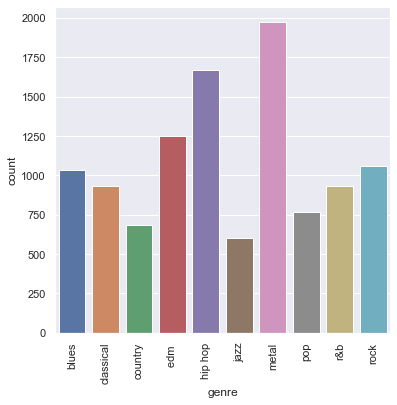

In [153]:
#Calculate genre wise track count
genre = df.groupby('genre', as_index=False).count()
genre  = genre[['genre','danceability']]
genre.columns = ['genre','count']

sns.set(rc = {'figure.figsize':(6,6)})
sns.barplot(data=genre, x='genre', y='count')
a = plt.xticks(rotation = 90)

We can see that rock, pop, and country music has higher popularity than the others.

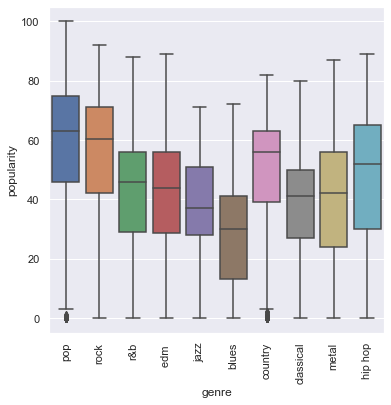

In [154]:
#Measure avg popularity over different genres
sns.boxplot(data=df, x='genre', y='popularity')
a=plt.xticks(rotation=90)


In [155]:
#Extract numeric columns
col_list = df.select_dtypes(include='number').columns
       

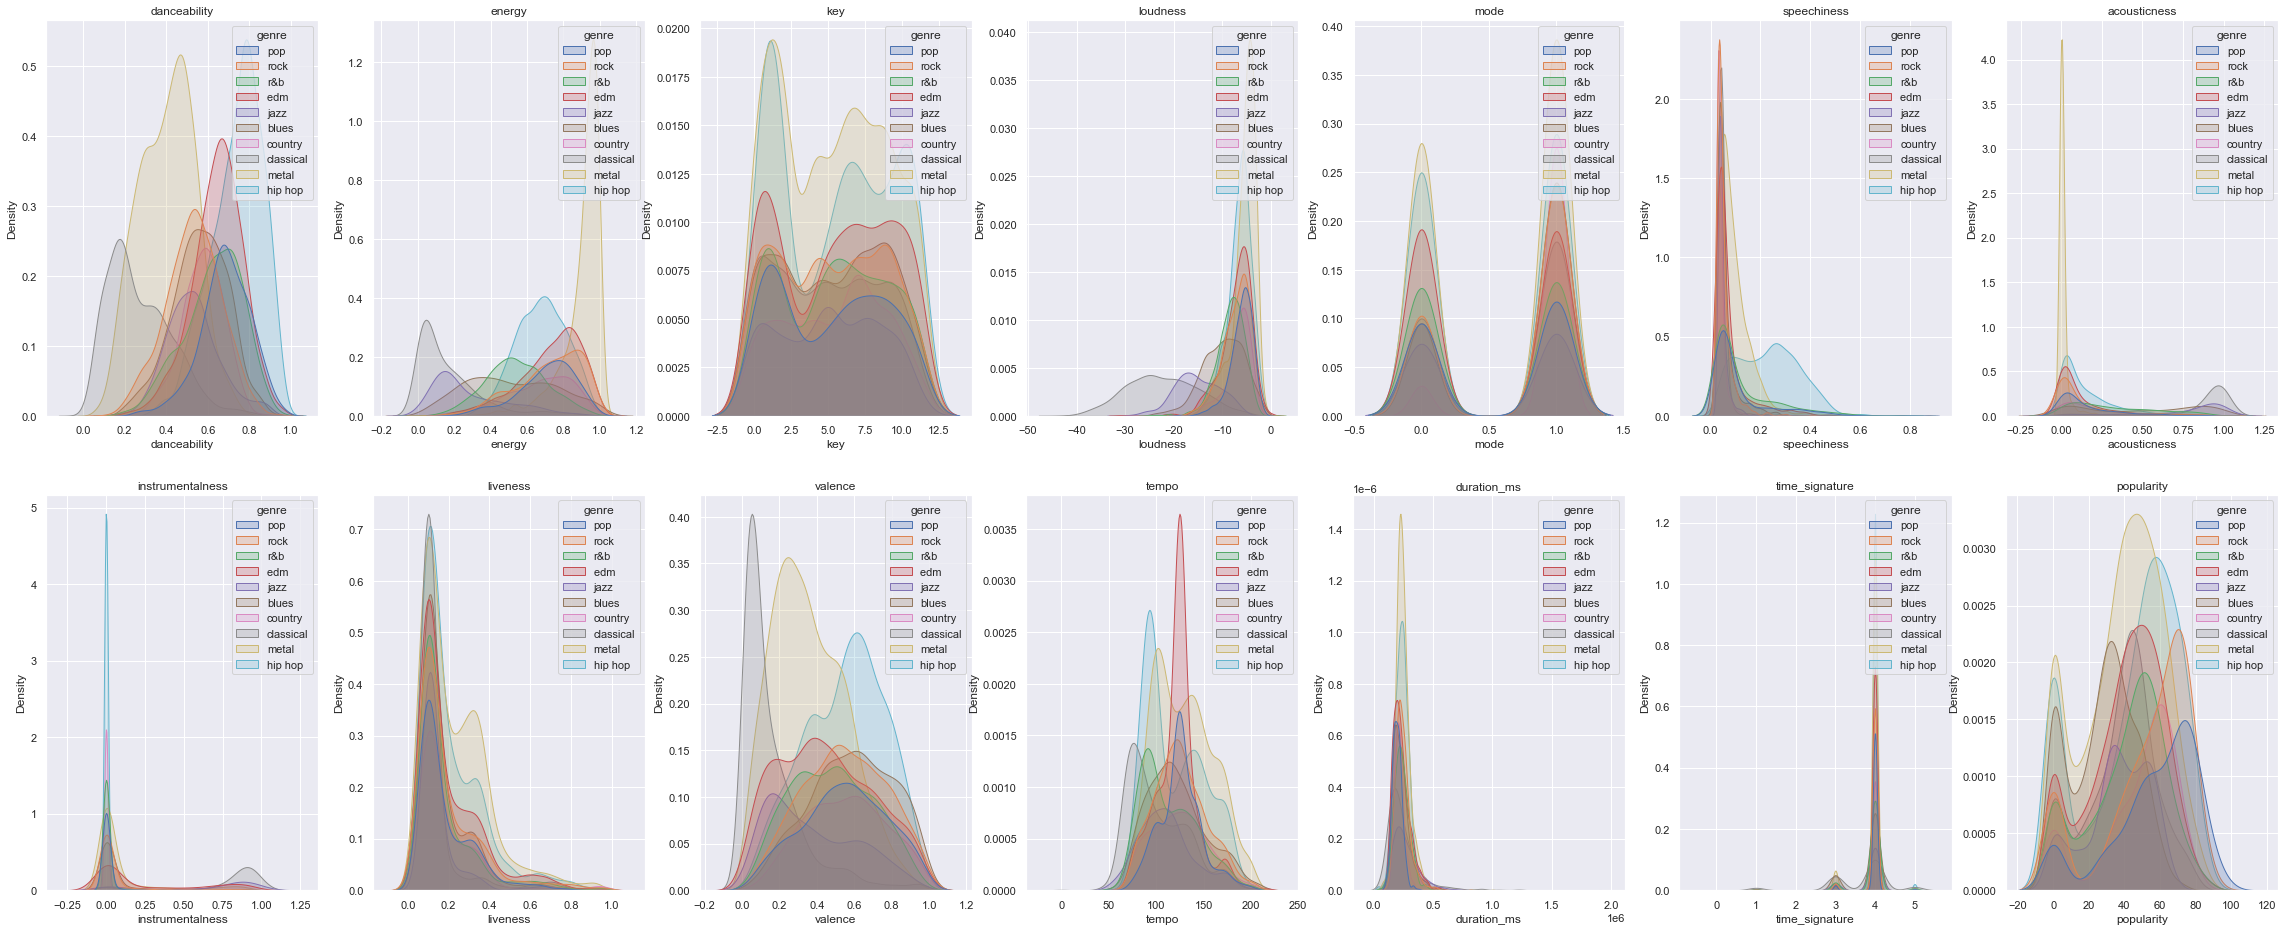

In [156]:
# Which features are more sensitive to music genres?
sns.set(rc = {'figure.figsize':(40,16)})
fig, axes = plt.subplots(2, 7)

col_idx = 0

for idx, col in enumerate(col_list):

    if idx<=6:
        sns.kdeplot(ax=axes[0,idx], data=df, x=col, hue='genre', fill=True).set_title(col)

    elif idx<14:
        if idx==7:
            col_idx=0
        sns.kdeplot(ax=axes[1,col_idx], data=df, x=col, hue='genre', fill=True).set_title(col)
        col_idx += 1



- By vizualizing the genre against other independent variables we can observe how the features vary for different genres. We can see that features like danceability, energy, loudness, valance, and tempo vary based on the genre significantly.
- Whereas, features like key, mode, duration, and time_signature are more robust.
- We can confirm these findings by carrying out a t-test for the mean feature values.

In [157]:
# Highlight the genres which report the highest/lowest avg values wrt each feature?
mean_df = df.groupby(['genre'], as_index=False).agg('mean')
mean_df.style.highlight_max(color = 'lightgreen', axis = 0, subset= col_list).highlight_min(color = 'pink', axis = 0, subset= col_list)


,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity
0,blues,0.562419,0.514593,5.270611,-9.919789,0.715810,0.059190,0.487088,0.075648,0.179038,0.583214,121.454909,229359.432590,3.806014,28.008729
1,classical,0.272566,0.169888,4.909871,-22.357763,0.641631,0.049537,0.840158,0.772028,0.144714,0.158965,100.934166,241247.010730,3.638412,37.869099
2,country,0.573912,0.659210,5.390351,-6.969814,0.899123,0.040609,0.248694,0.006529,0.192459,0.550811,124.317788,215535.416667,3.950292,47.888889
3,edm,0.645073,0.726650,5.477636,-7.140896,0.497604,0.076200,0.134069,0.255748,0.203143,0.444797,122.169137,230438.107827,3.968850,40.915335
4,hip hop,0.739445,0.677905,5.490408,-6.612578,0.536571,0.234903,0.152330,0.005988,0.213479,0.545313,119.817953,234400.748201,3.998201,45.141487
5,jazz,0.528662,0.292917,5.026622,-15.184428,0.532446,0.047812,0.736200,0.604074,0.156442,0.379047,110.946258,271737.535774,3.853577,36.202995
6,metal,0.403883,0.899116,5.240243,-5.562767,0.579828,0.097090,0.016886,0.106556,0.233770,0.359628,129.128429,245649.920426,3.946782,39.138875
7,pop,0.682939,0.703561,5.194771,-6.144878,0.552941,0.114216,0.168686,0.021408,0.184931,0.544326,125.201145,195230.104575,3.979085,56.941176
8,r&b,0.625061,0.540321,5.363636,-8.409929,0.511230,0.127004,0.333040,0.015840,0.179921,0.480084,113.411865,234243.448128,3.915508,41.272727
9,rock,0.528985,0.718119,5.217925,-7.248091,0.697170,0.051569,0.142118,0.064661,0.198008,0.544678,125.323168,242786.638679,3.957547,52.617925


This gives us a quick breakdown of our data. Some interesting observations we can notice are as below.

- metal genre has the highest avg energy, loudness, liveness, tempo and the lowest acousticness.
- hip-hop genre has the highest avg danceability, key, speechiness, and time signature while its avg instrumentalness is at the lowest.
- classical genre has the avg highest acousticness and	instrumentalness. Whereas avg danceability,	energy,	key, loudness, liveness, valence, tempo, and time signature are at the lowest.
- the highest avg popularity is reported by pop genre whereas the lowest is the blues.
- while jazz runs the avg longest duration pop has the avg shortest duration.



### Popularity

In our dataset we have two very interesting features, genre and popularity. We can use them to find answers to problems like, 

- what feature value combinations drive a song to be popular (e.g., > 80 in the poplarity index) ?
 

<AxesSubplot:xlabel='popularity', ylabel='Count'>

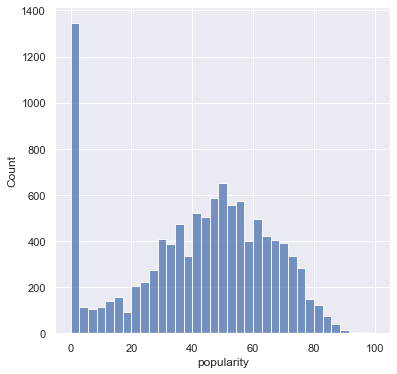

In [158]:
#popularity distribution

sns.set(rc = {'figure.figsize':(6,6)})
sns.histplot(df['popularity'])

We can see that there are many songs with popularity zero and less songs with high popularity.

In [159]:
#For each feature and popularity value we calculate their median
med_df = df.groupby(['popularity'], as_index=False).agg('median')

In [160]:
#vizualize using a parallel_coordinates graph
import plotly.express as px

fig = px.parallel_coordinates(med_df, color="popularity", dimensions=['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms', 'time_signature'],
                             color_continuous_scale=px.colors.diverging.Portland, #.Tealrose,
                             color_continuous_midpoint=50,
                             width=1500, height=500)
fig.show()

The below patterns can be observed from the parralel coordinates graph above.
- for very popular songs (popularity>=80), dancebility tends to be > 0.55, energy tends to be around 0.65-0.7, loudness tends to be > -6, acousticness tends to be < 0.15, instrumentalness tends to be very close to 0, and tempo tends to be between 120-130.
- for rest of the songs (popularity<80 including popularity 0 for the songs which wasn't on a chart), dancebility tends to be < 0.55, energy tends to be around 0.5-0.65, loudness tends to be < -6, acousticness tends to be > 0.15, instrumentalness tends to be 0.01-0.2, and tempo tends to be between 110-125.

This is a very generic overview. Remember based on the genre type the features that makes a successful song may change.

## Model training 

In this section we train a classification ML model to predict the music genre with from the audio features extracted from the Spotify API.

### Train/Test data split

In [161]:
X= df[col_list]
y= df['genre']

#label encoder for y
le = LabelEncoder().fit(y)
y = pd.Series(le.transform(y))

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data size : {}, Test data size {} ".format(X_train.shape, X_test.shape))

Training data size : (8720, 14), Test data size (2181, 14) 


In [162]:
#Check for the number of instances in each class. As there is faily a higher number of instances in every class, for now we do not carry out class balancing.
y_train.value_counts()

6    1574
4    1328
3    1018
9     845
0     831
1     747
8     744
7     616
2     560
5     457
dtype: int64

### Feature importance

<AxesSubplot:>

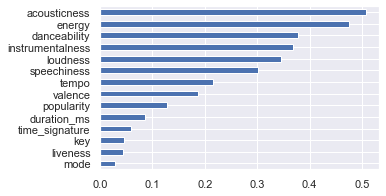

In [163]:
#information gain. mutual info

from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info, X_train.columns).sort_values()

sns.set(rc = {'figure.figsize':(5,3)})
mutual_info.plot(kind='barh')

We can see that features like acousticness, energy, dancebility, instrumentalness, loudness, and speechiness have stronger association with the genre compared to the other variables.

### Correlation analysis

<AxesSubplot:>

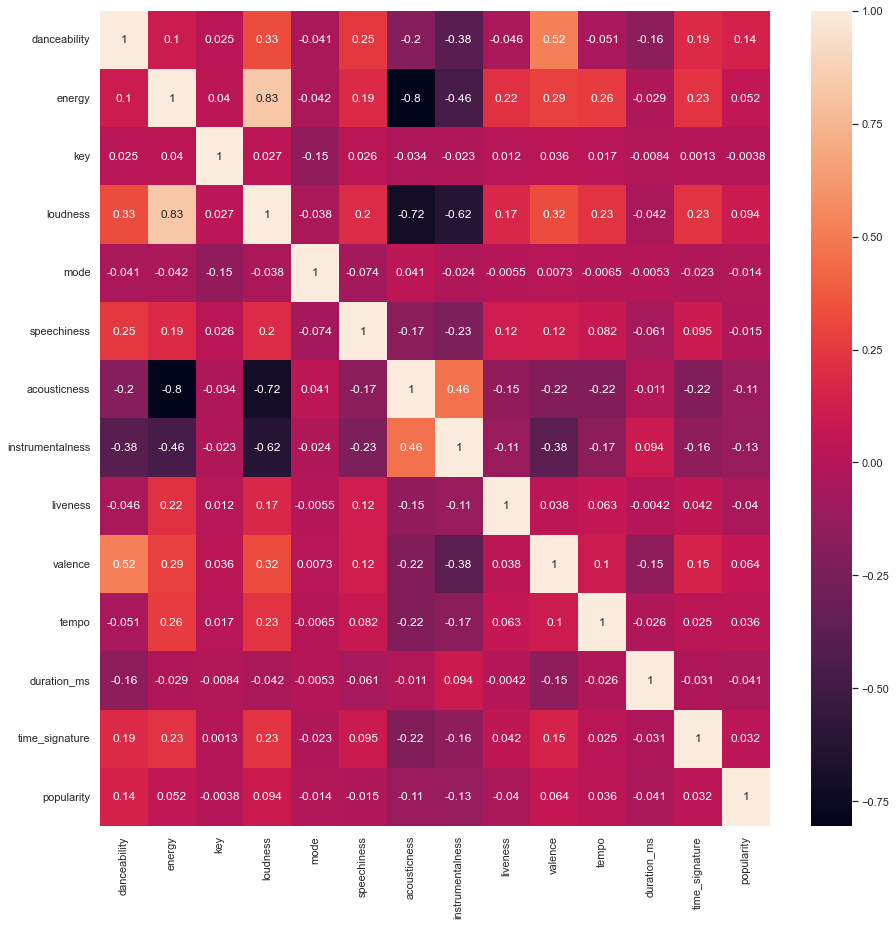

In [164]:
sns.set(rc = {'figure.figsize':(15,15)})
sns.heatmap(X_train.corr(),annot=True)

In [165]:
correlated_features=[]
for i in range(len(X_train.corr().columns)):
    for j in range(i):
        if abs(X_train.corr().iloc[i, j]) > 0.8:
            print(X_train.corr().columns[i], X_train.corr().columns[j])
            colname = X_train.corr().columns[i]


loudness energy
acousticness energy


We can see that energy has very high correlation (> 0.8) with loudness and acousticness. Hence, we drop this feature.

In [166]:
X_train.drop(columns=['energy'],axis=1, inplace=True)
X_test.drop(columns=['energy'],axis=1, inplace=True)

X_train.drop(columns=['mode'],axis=1, inplace=True)
X_test.drop(columns=['mode'],axis=1, inplace=True)

X_train.drop(columns=['key'],axis=1, inplace=True)
X_test.drop(columns=['key'],axis=1, inplace=True)

X_train.drop(columns=['liveness'],axis=1, inplace=True)
X_test.drop(columns=['liveness'],axis=1, inplace=True)

In [167]:
#ML model evalution

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn import metrics



def evalaute(pipeline, y_test_original, y_pred_original, show=True):

    if show: 
        print(metrics.classification_report(y_test_original, y_pred_original, digits=3))


        fig, ax = plt.subplots(figsize=(12, 8))
        plt.grid(False)
        cm = confusion_matrix(y_test_original, y_pred_original)
        cmp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test_original))
        cmp.plot(ax=ax)

        plt.show();
    else:
        rep  = metrics.classification_report(y_test_original, y_pred_original, digits=3,  output_dict=True)
        df_rep = pd.DataFrame(rep).transpose()
        return df_rep



### Pipeline with multiple estimators

In this section we train multiple classifiers on the data in order to find the best classification algorithm for the problem.

In [168]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [169]:
#Build pipeline 
pipeline = imbPipeline(steps=[
    ('scale', StandardScaler()),
    ('smote', SMOTE()),
    ('clf', RandomForestClassifier(random_state=42))
    ] )

In [192]:
clfs = []
clfs.append(LogisticRegression(max_iter=200, C=0.5, random_state=42))
clfs.append(SVC(random_state=42))
clfs.append(KNeighborsClassifier(n_neighbors=5))
clfs.append(DecisionTreeClassifier(max_depth=7, min_samples_split=5, random_state=42))
clfs.append(RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=5, random_state=42))
clfs.append(GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, random_state=42))
clfs.append(XGBClassifier(random_state=42))

In [193]:
#%%script false --no-raise-error 
for classifier in clfs:
    #set estimator as a seperate parameter
    pipeline.set_params(clf = classifier)

    #fit data
    pipeline.fit(X_train, y_train)

    scores = cross_validate(pipeline, X_train, y_train, cv = 5, return_train_score=True)
    print(str(classifier))
    print("Train accuracy : ", scores['train_score'].mean(), "CV accuracy : ",  scores['test_score'].mean())
    print('-----------------------------------')


LogisticRegression(C=0.5, max_iter=200, random_state=42)
Train accuracy :  0.5666284403669725 CV accuracy :  0.5605504587155963
-----------------------------------
SVC(random_state=42)
Train accuracy :  0.6606938073394496 CV accuracy :  0.611697247706422
-----------------------------------
KNeighborsClassifier()
Train accuracy :  0.7614392201834861 CV accuracy :  0.5302752293577983
-----------------------------------
DecisionTreeClassifier(max_depth=7, min_samples_split=5, random_state=42)
Train accuracy :  0.5485378440366973 CV accuracy :  0.5043577981651376
-----------------------------------
RandomForestClassifier(max_depth=7, min_samples_split=5, random_state=42)
Train accuracy :  0.6508314220183486 CV accuracy :  0.6002293577981652
-----------------------------------
GradientBoostingClassifier(learning_rate=0.05, random_state=42)
Train accuracy :  0.6939220183486239 CV accuracy :  0.6230504587155964
-----------------------------------
XGBClassifier(base_score=0.5, booster='gbtree'

So we have the best CV results from the XGBClassifier (0.637), followed by Gradient boosting (0.623) and Random forest (0.60). Hence, we use XGBClassifier for hyper parameter tunning with cross-validation.

### Pipeline with hyper parameter tunning and cross-validation

In [100]:
#%%script false --no-raise-error 

from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
        ('smote', SMOTE()),
        ('xgb', XGBClassifier())
    ])

In [102]:
#%%script false --no-raise-error 

params = {
    'xgb__learning_rate': [0.1, 0.01],
    'xgb__max_depth': [5],
    'xgb__min_child_weight': [5, 10],
    'xgb__colsample_bytree': [0.8, 0.9],
    'xgb__n_estimators': [500],
    'xgb__reg_lambda': [2, 3],
    'xgb__gamma': [1, 2],
    'xgb__colsample_bytree': [0.8, 1.0],
}

grid_search = GridSearchCV(estimator=pipe, param_grid=params, scoring="f1_macro", n_jobs=1, cv=3, error_score="raise", verbose=2)


grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__n_estimators=500, xgb__reg_lambda=2; total time=  18.7s
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__n_estimators=500, xgb__reg_lambda=2; total time=  15.4s
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__n_estimators=500, xgb__reg_lambda=2; total time=  14.5s
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__n_estimators=500, xgb__reg_lambda=3; total time=  13.9s
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__n_estimators=500, xgb__reg_lambda=3; total time=  14.0s
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=1,

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importan...
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=1,
             param_grid={'xgb__colsample_bytree': [0.8, 1.0],
                         'xgb__gamma': [1, 2],
                         'xgb__learning_rate': [0.1, 0.01],
                         'xgb__max_depth': [5],
                         'xgb__min_child_weight': [5, 10],
                         'xgb__n_estimators': [500],
                         'xgb__reg_lambda': [2, 3]},
             scoring='f1_macro', verbose=2)

In [121]:
#%%script false --no-raise-error 

print(grid_search.best_estimator_)


Pipeline(steps=[('smote', SMOTE()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=1, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=5, max_leaves=0, min_child_weight=5,
                               missing=nan, monotone_constraints='()',
                               n_estimators=500, n_jobs=0, num_parallel_tree=1,
                               objectiv

In [122]:
#%%script false --no-raise-error 

grid_search.best_score_


0.6150711675648162

              precision    recall  f1-score   support

       blues      0.586     0.560     0.573       200
   classical      0.906     0.886     0.896       185
     country      0.447     0.645     0.528       124
        edm       0.590     0.534     0.561       234
     hip hop      0.814     0.774     0.793       340
        jazz      0.704     0.660     0.681       144
       metal      0.808     0.789     0.798       399
         pop      0.430     0.497     0.461       149
         r&b      0.441     0.435     0.438       191
        rock      0.481     0.470     0.475       215

    accuracy                          0.647      2181
   macro avg      0.621     0.625     0.620      2181
weighted avg      0.656     0.647     0.650      2181



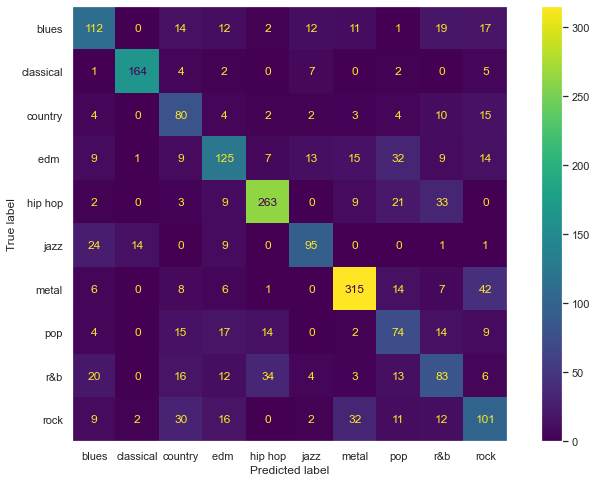

In [123]:
#%%script false --no-raise-error 

#predict
y_pred = grid_search.best_estimator_.predict(X_test)

#convert target variable to its original categorical form
y_pred_original = le.inverse_transform(y_pred)
y_test_original = le.inverse_transform(y_test)

evalaute(grid_search, y_test_original, y_pred_original)

- After hyper parameter tunning the accuracy has incresed to 0.647 from previous 0.637.
- The pop, r&b, and rock classes has the least accuracy.
- The confusion metrics indicates that most of the times,
    - the pop class gets misclassified as edm, the r&b class gets misclassified as hip hop, and the rock class is misclassified as metal.